# Configuration

In [ ]:
config = [
    
"--experimentdir", "/home/schindlera/experiments/ismir2020_reviews/",
"--modeldir"     , "/home/schindlera/experiments/ismir2020_reviews/",
    
"--relcontent"   , "rel_content_emb_tag_lsi_debug", 
"--audio"        , "melspec_128_10seconds_2ch_norm_debug", 
    
"--model"        , "kim2019",     
"--gpu"          , "0",
    
"--loss"         , "original", 
"--lossagg"      , "max", 
"--margin"       , "1.0", 
"--uppersim"     , "0.90", 
"--lowersim"     , "0.85", 
    
"--finaldim"     , "128", 
"--epochs"       , "10", 
"--learnrate"    , "0.0001",
"--batchsize"    , "1000"
    
]

# Data Loading & Preprocessing

In [ ]:
import sys
import argparse
import logging

In [3]:

parser = argparse.ArgumentParser()

parser.add_argument('--relcontent',    type=str)
parser.add_argument('--model',         type=str)
parser.add_argument('--audio',         type=str)
parser.add_argument('--experimentdir', type=str)
parser.add_argument('--modeldir',      type=str)
parser.add_argument('--gpu',           type=int)
parser.add_argument('--finaldim',      type=int)
parser.add_argument('--lossagg',       type=str, default="min")
parser.add_argument('--loss',          type=str, default="original")
parser.add_argument('--batchsize',     type=int, default=1000)
parser.add_argument('--margin',        type=float)
parser.add_argument('--learnrate',     type=float, default=0.0001)
parser.add_argument('--uppersim',      type=float)
parser.add_argument('--lowersim',      type=float)
parser.add_argument('--epochs',        type=int, default=100)
parser.add_argument("--log-level", default=logging.DEBUG, type=lambda x: getattr(logger, x), help="Configure the logger level.")

if sys.argv[0].find("ipykernel_launcher") != -1:
    args = parser.parse_args(config)
else:
    args = parser.parse_args()

# Imports

In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)

import json

import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tqdm.auto import tqdm

In [5]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from numpy.random import seed
from scipy.spatial.distance import cdist
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.constraints import MinMaxNorm, unit_norm
from tensorflow.keras.initializers import he_normal, he_uniform
from tensorflow.keras.layers import (ELU, AlphaDropout, AveragePooling2D,
                                     BatchNormalization, Concatenate, Conv2D,
                                     Dense, Dropout, Flatten, GaussianNoise,
                                     GlobalAveragePooling2D, Input, Lambda,
                                     LeakyReLU, MaxPooling2D, ReLU,
                                     SpatialDropout2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import normalize
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops, math_ops

import tensorflow_addons as tfa

In [6]:
# control random processes
np.random.seed(1)

In [7]:
# import model from definition file
from importlib import import_module
model_def = import_module(args.model)

# Functions

In [8]:
def prepare_model_dir(model_path):
    if not os.path.exists(model_path):
        os.makedirs(model_path)

# Initialize Experiment

## Init Logger

In [9]:
logger = logging.getLogger("experiment.py")
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

logger.info("+------------------------------------------------------------------+")
logger.info("| STARTING EXPERIMENT                                              |")
logger.info("+------------------------------------------------------------------+")
logger.info("Logger initialized")

logger.info("Initializing model experiment directory")
model_storage_path = prepare_model_dir(args.modeldir)

logger.info("Initializing logger filehandler")
fh = logging.FileHandler("%s/experiment.log" % args.modeldir)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

2020-04-29 14:59:11 - experiment.py - INFO - +------------------------------------------------------------------+
2020-04-29 14:59:11 - experiment.py - INFO - | STARTING EXPERIMENT                                              |
2020-04-29 14:59:11 - experiment.py - INFO - +------------------------------------------------------------------+
2020-04-29 14:59:11 - experiment.py - INFO - Logger initialized
2020-04-29 14:59:11 - experiment.py - INFO - Initializing model experiment directory
2020-04-29 14:59:11 - experiment.py - INFO - Initializing logger filehandler


Print Experiment Summary

In [10]:
logger.info("+------------------------------------------------------------------+")
logger.info("| EXPERIMENT:                                                      |")
logger.info("+------------------------------------------------------------------+")
logger.info("| Experiment directory              : %s"           % args.experimentdir)
logger.info("| Model-Directory                   : %s"           % args.modeldir)
logger.info("| Related content filename          : %s"           % args.relcontent)
logger.info("| Audio-Features filename           : %s"           % args.audio)
logger.info("| GPU                               : %d"           % args.gpu)
logger.info("+------------------------------------------------------------------+")
logger.info("| Model                             : %s"           % args.model)
logger.info("| Dimensions Final Music-Embeddings : %d"           % args.finaldim)
logger.info("+------------------------------------------------------------------+")
logger.info("| Loss                              : %s"           % args.loss)
logger.info("| Loss-Aggregation                  : %s"           % args.lossagg)
logger.info("| Upper Sim                         : %f"           % args.uppersim)
logger.info("| Margin                            : %f"           % args.margin)
logger.info("+------------------------------------------------------------------+")
logger.info("| Learn Rate                        : %f"           % args.learnrate)
logger.info("| Batch Size                        : %d"           % args.batchsize)
logger.info("| Num Epochs                        : %d"           % args.epochs)
logger.info("+------------------------------------------------------------------+")

2020-04-29 14:59:11 - experiment.py - INFO - +------------------------------------------------------------------+
2020-04-29 14:59:11 - experiment.py - INFO - | EXPERIMENT:                                                      |
2020-04-29 14:59:11 - experiment.py - INFO - +------------------------------------------------------------------+
2020-04-29 14:59:11 - experiment.py - INFO - | Experiment directory              : /home/schindlera/experiments/ismir2020_reviews/
2020-04-29 14:59:11 - experiment.py - INFO - | Model-Directory                   : /home/schindlera/experiments/ismir2020_reviews/
2020-04-29 14:59:11 - experiment.py - INFO - | Related content filename          : rel_content_emb_tag_lsi_debug
2020-04-29 14:59:11 - experiment.py - INFO - | Audio-Features filename           : melspec_128_10seconds_2ch_norm_debug
2020-04-29 14:59:11 - experiment.py - INFO - | GPU                               : 0
2020-04-29 14:59:11 - experiment.py - INFO - +--------------------------------

Store configuration for reproducability

In [11]:
with open("%s/experiment_arguments.json" % args.modeldir, 'w') as json_file:
    args_json = json.dump(vars(args), json_file)

## Load Audio Data

In [12]:
logger.info("* Load Audio Data")

2020-04-29 14:59:11 - experiment.py - INFO - * Load Audio Data


Load Audio Data - Train Partition

In [13]:
%%time
logger.info("* Load Audio Data - Train Partition")

# load partition trackid file
par_file           = "%s/eval_partition_trackids_train.csv" % (args.experimentdir)
par_trackids_train = pd.read_csv(par_file, header=None, index_col=0)

# load audio content
par_filename_audio_train = "%s/%s_train.npz" % (args.experimentdir, args.audio)

with np.load(par_filename_audio_train, allow_pickle=True) as npz:
    data_audio_train      = npz["data"]
    track_ids_audio_train = npz["track_ids"].astype(str)
    
lookup_audio_train = pd.DataFrame(np.arange(track_ids_audio_train.shape[0], dtype=int), 
                                  index   = track_ids_audio_train, 
                                  columns = ["feature_line_nr"])

2020-04-29 14:59:11 - experiment.py - INFO - * Load Audio Data - Train Partition
CPU times: user 10 s, sys: 4.74 s, total: 14.7 s
Wall time: 22.3 s


In [14]:
# CHECK: ids and data have same length
assert(data_audio_train.shape[0] == track_ids_audio_train.shape[0])

In [15]:
#par_trackids_train.index.values == track_ids_audio_train

Load Audio Data - Validation Partition

In [16]:
logger.info("* Load Audio Data - Validation Partition")

# load partition trackid file
par_file         = "%s/eval_partition_trackids_val.csv" % (args.experimentdir)
par_trackids_val = pd.read_csv(par_file, header=None, index_col=0)

# load audio content
par_filename_audio_val = "%s/%s_val.npz" % (args.experimentdir, args.audio)

with np.load(par_filename_audio_val, allow_pickle=True) as npz:
    data_audio_val      = npz["data"]
    track_ids_audio_val = npz["track_ids"].astype(str)
    
lookup_audio_val = pd.DataFrame(np.arange(track_ids_audio_val.shape[0], dtype=int), 
                                  index   = track_ids_audio_val, 
                                  columns = ["feature_line_nr"])

2020-04-29 14:59:33 - experiment.py - INFO - * Load Audio Data - Validation Partition


In [17]:
# CHECK: ids and data have same length
assert(data_audio_val.shape[0] == track_ids_audio_val.shape[0])

In [18]:
logger.info("Num instances - audio data train : %d" % data_audio_train.shape[0])
logger.info("Num instances - audio data val   : %d" % data_audio_val.shape[0])
logger.info("data_audio dimensions            : %s" % str(data_audio_train.shape))

2020-04-29 14:59:39 - experiment.py - INFO - Num instances - audio data train : 10000
2020-04-29 14:59:39 - experiment.py - INFO - Num instances - audio data val   : 2500
2020-04-29 14:59:39 - experiment.py - INFO - data_audio dimensions            : (10000, 128, 880, 2)


## Load Related Content

In [19]:
logger.info("* Load Related Content Embeddings")

2020-04-29 14:59:39 - experiment.py - INFO - * Load Related Content Embeddings


Train Partition

In [20]:
par_filename_relcontent_train = "%s/%s_train.npz" % (args.experimentdir, args.relcontent)

with np.load(par_filename_relcontent_train, allow_pickle=True) as npz:
    data_relcontent_train     = npz["data"]
    trackids_relcontent_train = npz["trackids"].astype(str)

lookup_relcontent_train = pd.DataFrame(np.arange(trackids_relcontent_train.shape[0], dtype=int), 
                                       index   = trackids_relcontent_train, 
                                       columns = ["feature_line_nr"])

# CHECK: ids and data have same length
assert(data_relcontent_train.shape[0] == trackids_relcontent_train.shape[0])

# CHECK: ids of text and audio are aligned
#assert((track_ids_text == track_ids_audio).sum() == track_ids_audio.shape[0])

Validation Partition

In [21]:
par_filename_relcontent_val = "%s/%s_val.npz" % (args.experimentdir, args.relcontent)

with np.load(par_filename_relcontent_val, allow_pickle=True) as npz:
    data_relcontent_val     = npz["data"]
    trackids_relcontent_val = npz["trackids"].astype(str)

lookup_relcontent_val = pd.DataFrame(np.arange(trackids_relcontent_val.shape[0], dtype=int), 
                                       index   = trackids_relcontent_val, 
                                       columns = ["feature_line_nr"])

# CHECK: ids and data have same length
assert(data_relcontent_val.shape[0] == trackids_relcontent_val.shape[0])

# CHECK: ids of text and audio are aligned
#assert((track_ids_text == track_ids_audio).sum() == track_ids_audio.shape[0])

In [22]:
logger.info("Num instances - related content train : %d" % data_relcontent_train.shape[0])
logger.info("Num instances - related content val   : %d" % data_relcontent_val.shape[0])
logger.info("data_relcontent dimensions            : %s" % str(data_relcontent_train.shape))
logger.info("TEXT_EMBEDDINGS_DIMENSIONS            : %d" % data_relcontent_train.shape[1])
logger.info("+------------------------------------------------------------------+")

2020-04-29 14:59:39 - experiment.py - INFO - Num instances - related content train : 10000
2020-04-29 14:59:39 - experiment.py - INFO - Num instances - related content val   : 2500
2020-04-29 14:59:39 - experiment.py - INFO - data_relcontent dimensions            : (10000, 340)
2020-04-29 14:59:39 - experiment.py - INFO - TEXT_EMBEDDINGS_DIMENSIONS            : 340
2020-04-29 14:59:39 - experiment.py - INFO - +------------------------------------------------------------------+


In [23]:
TEXT_EMBEDDINGS_DIMENSIONS = data_relcontent_train.shape[1]

logger.info("Partitions overview - train/val")

logger.info("data_audio_train      dimensions    : %s" % str(data_audio_train.shape))
logger.info("data_relcontent_train dimensions    : %s" % str(data_relcontent_train.shape))
logger.info("data_audio_val        dimensions    : %s" % str(data_audio_val.shape))
logger.info("data_relcontent_val   dimensions    : %s" % str(data_relcontent_val.shape))
logger.info("+------------------------------------------------------------------+")

2020-04-29 14:59:39 - experiment.py - INFO - Partitions overview - train/val
2020-04-29 14:59:39 - experiment.py - INFO - data_audio_train      dimensions    : (10000, 128, 880, 2)
2020-04-29 14:59:39 - experiment.py - INFO - data_relcontent_train dimensions    : (10000, 340)
2020-04-29 14:59:39 - experiment.py - INFO - data_audio_val        dimensions    : (2500, 128, 880, 2)
2020-04-29 14:59:39 - experiment.py - INFO - data_relcontent_val   dimensions    : (2500, 340)
2020-04-29 14:59:39 - experiment.py - INFO - +------------------------------------------------------------------+


# Model

## Loss

In [24]:
expDtype = tf.float32
epsilon  = 1e-16

In [25]:
def pairwise_similarity_cosine(feature):

    feature            = K.l2_normalize(feature,axis=1)
    pairwise_distances = tf.matmul(feature, feature, adjoint_b = True)
    
    return pairwise_distances
    

In [26]:
#import seaborn as sns
#%matplotlib inline

#sns.heatmap(mask_positive_bool)

# Model

In [27]:
class LoggerCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        logger.info("+------------------------------------------------------------------+")
        logger.info("| TRAINING BEGIN                                                   |")
        logger.info("+------------------------------------------------------------------+")

    def on_epoch_end(self, epoch, logs=None):
        logger.info('Epoch %d: train_loss %f - val_loss %f' % (epoch, logs['loss'], logs['val_loss']))

    def on_train_end(self, logs=None):
        logger.info("+------------------------------------------------------------------+")
        logger.info("| TRAINING END                                                     |")
        logger.info("+------------------------------------------------------------------+")

In [28]:
def triplet_loss_soft(text_embdeeings, audio_embeddings):
        

    #audio_embeddings = embeddings
    #audio_embeddings.shape
    #text_embdeeings = data_relcontent_train[:100]
    
    margin = tf.constant(args.margin)

    #tf.print(audio_embeddings[0])
        
    # normalize embeddings
    audio_embeddings = tf.nn.l2_normalize(audio_embeddings, 1, 1e-10, name='embeddings')
    #text_embdeeings  = K.l2_normalize(text_embdeeings  ,axis=1)
    
    # Get the pairwise distance matrix
    pairwise_dists_text  = pairwise_similarity_cosine(text_embdeeings)
    pairwise_dists_audio = tfa.losses.metric_learning.pairwise_distance(audio_embeddings, squared=False)
    
    # create filter masks
    
    # utils
    diag_zeros = tf.linalg.diag_part(pairwise_dists_text) * 0
    diag_false = tf.cast(diag_zeros, tf.bool)
    max_pairwise_dists_audio  = tf.reduce_max(pairwise_dists_audio, keepdims=True)
    
    # positive bool mask
    max_pairwise_dists_text      = tf.reduce_max(pairwise_dists_text, axis=1, keepdims=True)
    mask_max_pairwise_dists_text = tf.equal(pairwise_dists_text, max_pairwise_dists_text)
    
    mask_positive_bool      = tf.greater(pairwise_dists_text, args.uppersim)
    mask_positive_bool      = tf.math.logical_and(mask_positive_bool, mask_max_pairwise_dists_text)
    
    mask_positive_bool      = tf.linalg.set_diag(mask_positive_bool, diag_false)
    
    # negative bool mask
    #mask_negative_bool = tf.less(pairwise_dists_text, UPPER_SIM)
    #mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    
    mask_negative_bool = tf.less(pairwise_dists_text, args.lowersim)
    mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    

    # positive
    mask_positive_float       = tf.cast(mask_positive_bool, dtype=expDtype)
    mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    
    if args.lossagg == "max":
        
        audio_positive_dist       = pairwise_dists_audio * mask_positive_float
        hardest_positive_dist     = tf.reduce_max(audio_positive_dist, axis=1, keepdims=True)
    
    elif args.lossagg == "min":
    
        audio_positive_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_positive_float)
        hardest_positive_dist     = tf.reduce_min(audio_positive_dist, axis=1, keepdims=True)

    # negative
    mask_greater_as_hard_pos  = tf.greater(pairwise_dists_audio, hardest_positive_dist)
    mask_greater_zero         = tf.greater(pairwise_dists_audio + margin, hardest_positive_dist)
    mask_negative_bool        = tf.math.logical_and(mask_negative_bool, mask_greater_as_hard_pos)
    mask_negative_bool        = tf.math.logical_and(mask_negative_bool, mask_greater_zero)
    mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    audio_negative_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_negative_float)
    hardest_negative_dist     = tf.reduce_min(audio_negative_dist, axis=1, keepdims=True)

    # only use triplets where a positive and negative examples were identified
    #mask_positive_bool_any    = tf.reduce_any(mask_positive_bool, axis=1, keepdims=True)
    #mask_negative_bool_any    = tf.reduce_any(mask_negative_bool, axis=1, keepdims=True)
        
    # final mask
    #final_mask                = tf.math.logical_and(mask_positive_bool_any, mask_negative_bool_any)
    #final_mask_float          = tf.cast(final_mask, dtype=expDtype)
    #final_mask = mask_positive_bool_any
    
    #hardest_positive_dist     = tf.boolean_mask(hardest_positive_dist, final_mask)
    #hardest_negative_dist     = tf.boolean_mask(hardest_negative_dist, final_mask)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    delta               = hardest_positive_dist - hardest_negative_dist
    

    #tf.print("delta", delta)
    #valid_positives     = tf.reduce_max(mask_positive_float, axis=1, keepdims=True)
    #num_valid_positives = tf.reduce_sum(valid_positives)
    
    #tf.print(num_valid_positives, 
    #         tf.reduce_mean(hardest_positive_dist), 
    #         tf.reduce_mean(hardest_negative_dist))
    
    #x = tf.constant(0, name='x')
    
    #if tf.equal(hardest_positive_dist.shape[0], x):
        
    #    triplet_loss = 0

        
    #else:
        
    delta_hinge = tf.maximum(delta + margin, 0.0)
    
    #delta_hinge               = delta_hinge * final_mask_float
    
    #tf.print("delta_hinge", delta_hinge)
    
    triplet_loss = tf.reduce_mean(delta_hinge) # eigentlich auch hinge
    #triplet_loss = triplet_loss / num_valid_positives # mean (excluding non valid pairs)
    
    #tf.print("triplet_loss", triplet_loss)

    
    #if   args.loss == "original"     :    
    #elif args.loss == "logistic_sum" : triplet_loss = tf.reduce_sum (tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "logistic_mean": triplet_loss = tf.reduce_mean(tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "hinge_sum"    : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "hinge_mean"   : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "exp_sum"      : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.exp(delta), axis=2))
    #elif args.loss == "exp_mean"     : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.exp(delta), axis=2))
    #else: raise NotImplementedError

    return triplet_loss

In [29]:
def triplet_loss_hard(text_embdeeings, audio_embeddings):
        

    #audio_embeddings = embeddings
    #audio_embeddings.shape
    #text_embdeeings = data_relcontent_train[:100]
    
    margin = tf.constant(args.margin)

    #tf.print(audio_embeddings[0])
        
    # normalize embeddings
    audio_embeddings = tf.nn.l2_normalize(audio_embeddings, 1, 1e-10, name='embeddings')
    #text_embdeeings  = K.l2_normalize(text_embdeeings  ,axis=1)
    
    # Get the pairwise distance matrix
    pairwise_dists_text  = pairwise_similarity_cosine(text_embdeeings)
    pairwise_dists_audio = tfa.losses.metric_learning.pairwise_distance(audio_embeddings, squared=False)
    
    # create filter masks
    
    # utils
    diag_zeros = tf.linalg.diag_part(pairwise_dists_text) * 0
    diag_false = tf.cast(diag_zeros, tf.bool)
    max_pairwise_dists_audio  = tf.reduce_max(pairwise_dists_audio, keepdims=True)
    
    # positive bool mask
    max_pairwise_dists_text      = tf.reduce_max(pairwise_dists_text, axis=1, keepdims=True)
    mask_max_pairwise_dists_text = tf.equal(pairwise_dists_text, max_pairwise_dists_text)
    
    mask_positive_bool      = tf.greater(pairwise_dists_text, args.uppersim)
    mask_positive_bool      = tf.math.logical_and(mask_positive_bool, mask_max_pairwise_dists_text)
    
    mask_positive_bool      = tf.linalg.set_diag(mask_positive_bool, diag_false)
    
    # negative bool mask
    #mask_negative_bool = tf.less(pairwise_dists_text, UPPER_SIM)
    #mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    
    mask_negative_bool = tf.less(pairwise_dists_text, args.lowersim)
    mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    

    # positive
    mask_positive_float       = tf.cast(mask_positive_bool, dtype=expDtype)
    mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    
    if args.lossagg == "max":
        
        audio_positive_dist       = pairwise_dists_audio * mask_positive_float
        hardest_positive_dist     = tf.reduce_max(audio_positive_dist, axis=1, keepdims=True)
    
    elif args.lossagg == "min":
    
        audio_positive_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_positive_float)
        hardest_positive_dist     = tf.reduce_min(audio_positive_dist, axis=1, keepdims=True)

    # negative
    #mask_greater_as_hard_pos  = tf.greater(pairwise_dists_audio, hardest_positive_dist)
    #mask_greater_zero         = tf.greater(pairwise_dists_audio + margin, hardest_positive_dist)
    #mask_negative_bool        = tf.math.logical_and(mask_negative_bool, mask_greater_as_hard_pos)
    #mask_negative_bool        = tf.math.logical_and(mask_negative_bool, mask_greater_zero)
    #mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    audio_negative_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_negative_float)
    hardest_negative_dist     = tf.reduce_min(audio_negative_dist, axis=1, keepdims=True)

    # only use triplets where a positive and negative examples were identified
    mask_positive_bool_any    = tf.reduce_any(mask_positive_bool, axis=1, keepdims=True)
    mask_negative_bool_any    = tf.reduce_any(mask_negative_bool, axis=1, keepdims=True)
        
    # final mask
    final_mask                = tf.math.logical_and(mask_positive_bool_any, mask_negative_bool_any)
    final_mask_float          = tf.cast(final_mask, dtype=expDtype)
    #final_mask = mask_positive_bool_any
    
    #hardest_positive_dist     = tf.boolean_mask(hardest_positive_dist, final_mask)
    #hardest_negative_dist     = tf.boolean_mask(hardest_negative_dist, final_mask)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    delta               = hardest_positive_dist - hardest_negative_dist
    

    #tf.print("delta", delta)
    valid_positives     = tf.reduce_max(mask_positive_float, axis=1, keepdims=True)
    num_valid_positives = tf.reduce_sum(valid_positives)
    
    tf.print(num_valid_positives, 
             tf.reduce_mean(hardest_positive_dist), 
             tf.reduce_mean(hardest_negative_dist))
    
    #x = tf.constant(0, name='x')
    
    #if tf.equal(hardest_positive_dist.shape[0], x):
        
    #    triplet_loss = 0

        
    #else:
        
    delta_hinge = tf.maximum(delta + margin, 0.0)
    
    #delta_hinge               = delta_hinge * final_mask_float
    
    #tf.print("delta_hinge", delta_hinge)
    
    triplet_loss = tf.reduce_mean(delta_hinge) # eigentlich auch hinge
    #triplet_loss = triplet_loss / num_valid_positives # mean (excluding non valid pairs)
    
    #tf.print("triplet_loss", triplet_loss)

    
    #if   args.loss == "original"     :    
    #elif args.loss == "logistic_sum" : triplet_loss = tf.reduce_sum (tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "logistic_mean": triplet_loss = tf.reduce_mean(tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "hinge_sum"    : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "hinge_mean"   : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "exp_sum"      : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.exp(delta), axis=2))
    #elif args.loss == "exp_mean"     : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.exp(delta), axis=2))
    #else: raise NotImplementedError

    return triplet_loss

In [41]:
def triplet_loss_soft(text_embdeeings, audio_embeddings):
        

    #audio_embeddings = embeddings
    #audio_embeddings.shape
    #text_embdeeings = data_relcontent_train[:100]
        
    margin = tf.constant(args.margin)

    #tf.print(audio_embeddings[0])
        
    # normalize embeddings
    audio_embeddings = tf.nn.l2_normalize(audio_embeddings, 1, 1e-10, name='embeddings')
    #text_embdeeings  = K.l2_normalize(text_embdeeings  ,axis=1)

    emb_a = audio_embeddings[:100,:]
    emb_p = audio_embeddings[100:200,:]
    
    tf.print(emb_a.shape, emb_p.shape)
    
    hardest_positive_dist  =  tf.sqrt(tf.reduce_sum(tf.pow(emb_a - emb_p, 2), axis=1))
    
    tf.print(hardest_positive_dist.shape)
    tf.print(hardest_positive_dist)
    
    # Get the pairwise distance matrix
    #pairwise_dists_text  = pairwise_similarity_cosine(text_embdeeings)
    pairwise_dists_audio = tfa.losses.metric_learning.pairwise_distance(audio_embeddings, squared=False)
    
    # create filter masks
    
    # utils
    diag_zeros = tf.linalg.diag_part(pairwise_dists_audio) * 0
    diag_false = tf.cast(diag_zeros, tf.bool)
    max_pairwise_dists_audio  = tf.reduce_max(pairwise_dists_audio, keepdims=True)
    
    # positive bool mask
    #max_pairwise_dists_text      = tf.reduce_max(pairwise_dists_text, axis=1, keepdims=True)
    #mask_max_pairwise_dists_text = tf.equal(pairwise_dists_text, max_pairwise_dists_text)
    
    #mask_positive_bool      = tf.greater(pairwise_dists_text, args.uppersim)
    #mask_positive_bool      = tf.math.logical_and(mask_positive_bool, mask_max_pairwise_dists_text)
    
    #mask_positive_bool      = tf.linalg.set_diag(mask_positive_bool, diag_false)
    
    # negative bool mask
    #mask_negative_bool = tf.less(pairwise_dists_text, UPPER_SIM)
    #mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    
    #mask_negative_bool = tf.less(pairwise_dists_text, args.lowersim)
    #mask_negative_bool = tf.linalg.set_diag(mask_negative_bool, diag_false)    

    # positive
    #mask_positive_float       = tf.cast(mask_positive_bool, dtype=expDtype)
    #mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    
    #if args.lossagg == "max":
    #    
    #    audio_positive_dist       = pairwise_dists_audio * mask_positive_float
    #    hardest_positive_dist     = tf.reduce_max(audio_positive_dist, axis=1, keepdims=True)
    
    #elif args.lossagg == "min":
    
    #    audio_positive_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_positive_float)
    #    hardest_positive_dist     = tf.reduce_min(audio_positive_dist, axis=1, keepdims=True)

    # negative
    mask_greater_as_hard_pos  = tf.greater(pairwise_dists_audio[:100], hardest_positive_dist)
    mask_greater_zero         = tf.greater(pairwise_dists_audio[:100] + margin, hardest_positive_dist)
    mask_negative_bool        = tf.math.logical_and(mask_greater_zero, mask_greater_as_hard_pos)
    #mask_negative_bool        = tf.math.logical_and(mask_negative_bool, mask_greater_zero)
    mask_negative_float       = tf.cast(mask_negative_bool, dtype=expDtype)
    audio_negative_dist       = pairwise_dists_audio + max_pairwise_dists_audio * (1.0 - mask_negative_float)
    hardest_negative_dist     = tf.reduce_min(audio_negative_dist, axis=1, keepdims=True)

    # only use triplets where a positive and negative examples were identified
    #mask_positive_bool_any    = tf.reduce_any(mask_positive_bool, axis=1, keepdims=True)
    #mask_negative_bool_any    = tf.reduce_any(mask_negative_bool, axis=1, keepdims=True)
        
    # final mask
    #final_mask                = tf.math.logical_and(mask_positive_bool_any, mask_negative_bool_any)
    #final_mask_float          = tf.cast(final_mask, dtype=expDtype)
    #final_mask = mask_positive_bool_any
    
    #hardest_positive_dist     = tf.boolean_mask(hardest_positive_dist, final_mask)
    #hardest_negative_dist     = tf.boolean_mask(hardest_negative_dist, final_mask)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    delta               = hardest_positive_dist - hardest_negative_dist
    

    #tf.print("delta", delta)
    #valid_positives     = tf.reduce_max(mask_positive_float, axis=1, keepdims=True)
    #num_valid_positives = tf.reduce_sum(valid_positives)
    
    #tf.print(num_valid_positives, 
    #         tf.reduce_mean(hardest_positive_dist), 
    #         tf.reduce_mean(hardest_negative_dist))
    
    #x = tf.constant(0, name='x')
    
    #if tf.equal(hardest_positive_dist.shape[0], x):
        
    #    triplet_loss = 0

        
    #else:
        
    delta_hinge = tf.maximum(delta + margin, 0.0)
    
    #delta_hinge               = delta_hinge * final_mask_float
    
    #tf.print("delta_hinge", delta_hinge)
    
    triplet_loss = tf.reduce_mean(delta_hinge) # eigentlich auch hinge
    #triplet_loss = triplet_loss / num_valid_positives # mean (excluding non valid pairs)
    
    #tf.print("triplet_loss", triplet_loss)

    
    #if   args.loss == "original"     :    
    #elif args.loss == "logistic_sum" : triplet_loss = tf.reduce_sum (tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "logistic_mean": triplet_loss = tf.reduce_mean(tf.log1p(tf.reduce_sum(tf.exp(delta), axis=2)))
    #elif args.loss == "hinge_sum"    : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "hinge_mean"   : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.relu(args.margin + delta)))
    #elif args.loss == "exp_sum"      : triplet_loss = tf.reduce_sum (tf.reduce_sum(tf.exp(delta), axis=2))
    #elif args.loss == "exp_mean"     : triplet_loss = tf.reduce_mean(tf.reduce_sum(tf.exp(delta), axis=2))
    #else: raise NotImplementedError

    return triplet_loss

In [42]:
# ===============================================================================
# # Train Model
# ===============================================================================

logger.info("* Prepare Evaluation")

# ===============================================================================
# ### Build and Train Model
# ===============================================================================

# define the model
model = model_def.get_model(args.finaldim)

logger.info("* Model created")

# define the optimizer
opt = Adam(lr=args.learnrate)
#opt = SGD(lr=0.0001)
#opt = tfa.optimizers.RectifiedAdam(lr=1e-4)

logger.info("* Optimizer: %s" % (str(opt)))


#from keras_radam import RAdam

#opt = RAdam(total_steps=10000, warmup_proportion=0.1, learning_rate=1e-4, min_lr=1e-5)

# compile the model
model.compile(loss      = triplet_loss_soft,
              optimizer = opt)
logger.info("* Model compiled")
                    
# ===============================================================================
# Callbacks
# ===============================================================================

cb_modelcheckpoint = ModelCheckpoint(args.modeldir + "/model.h5", 
                                    monitor           = 'val_loss', 
                                    verbose           = 1, 
                                    save_best_only    = True, 
                                    save_weights_only = True, 
                                    mode              = 'auto')
    
cb_tensorboard =  TensorBoard(log_dir=args.modeldir, 
                                histogram_freq=0, 
                                write_graph=False, 
                                write_grads=False, 
                                write_images=False, 
                                embeddings_freq=0, 
                                embeddings_layer_names=None, 
                                embeddings_metadata=None, 
                                embeddings_data=None, 
                                update_freq='epoch')

cb_csv_logger = CSVLogger(args.modeldir + "/model_training_log.csv", separator=';', append=False)

cb_logger = LoggerCallback()
    
callbacks = [cb_tensorboard, 
             cb_modelcheckpoint, 
             cb_csv_logger, 
             cb_logger]
logger.info("* Callbacks created")

2020-04-29 15:14:23 - experiment.py - INFO - * Prepare Evaluation
2020-04-29 15:14:23 - experiment.py - INFO - * Model created
2020-04-29 15:14:23 - experiment.py - INFO - * Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f20f43d7898>
2020-04-29 15:14:23 - experiment.py - INFO - * Model compiled
2020-04-29 15:14:23 - experiment.py - INFO - * Callbacks created


In [33]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, audio, relcontent, batch_size=32, shuffle=True):

        self.audio      = audio
        self.relcontent = relcontent
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.sample_size = int(self.batch_size / 3)
        
        self.indexes    = np.arange(self.audio.shape[0])
        
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(self.indexes.shape[0] / (self.sample_size)))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        sample_idx_orig = self.indexes[index * self.sample_size:(index + 1) * self.sample_size]

        triplet_indexes = self._get_indexes(sample_idx_orig)
        
        return self.audio[triplet_indexes], self.relcontent[triplet_indexes]
            

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _get_indexes(self, sample_idx_orig):
        
        sample_size_large = self.sample_size * 10
        
        #print(sample_size_large)
        
        sample_idx = np.random.randint(0,self.relcontent.shape[0], sample_size_large)
        sample_idx = np.setdiff1d(sample_idx, sample_idx_orig)[:sample_size_large - self.sample_size]
        sample_idx = np.concatenate([sample_idx_orig, sample_idx], axis=0)

        sample     = self.relcontent[sample_idx]

        sample_cossim    = 1 - cdist(sample, sample, metric='cosine')
        np.fill_diagonal(sample_cossim, 0)

        max_sample_idx_a = np.arange(sample_idx.shape[0])

        max_sample       = sample_cossim.max(axis=1)
        max_sample_idx_p = sample_cossim.argmax(axis=1)

        anchor_positive_pairs = np.asarray([max_sample_idx_a, max_sample_idx_p]).T
        #print(anchor_positive_pairs.shape, max_sample.shape)
        anchor_positive_pairs = anchor_positive_pairs[max_sample >= args.uppersim]

        np.sort(anchor_positive_pairs, axis=1)

        anchor_positive_pairs = np.unique(anchor_positive_pairs, axis=0)

        for j in [0,1]:

            valid_indexes = []
            last_val = -1

            for i in np.argsort(anchor_positive_pairs[:,j]):

                #print(last_val, anchor_positive_pairs[i,j])
                if anchor_positive_pairs[i,j] != last_val:
                    valid_indexes.append(i)
                    last_val = anchor_positive_pairs[i,j]

            anchor_positive_pairs = anchor_positive_pairs[valid_indexes]

        anchor_positive_pairs = anchor_positive_pairs[:self.sample_size]

        negative_samples = sample_cossim[anchor_positive_pairs[:,0]] * (sample_cossim[anchor_positive_pairs[:,0]] < args.lowersim)

        unique_indexes = anchor_positive_pairs.flatten().tolist()

        max_sample_idx_n = []

        for i in range(negative_samples.shape[0]):

            sorted_indexes = np.argsort(negative_samples[i,:])[::-1]

            for idx in sorted_indexes:
                if idx not in unique_indexes:
                    max_sample_idx_n.append(idx)
                    unique_indexes.append(idx)
                    break

        triplets = np.concatenate([anchor_positive_pairs, np.expand_dims(max_sample_idx_n, axis=1)], axis=1)

        batch_idx = sample_idx[triplets.flatten()]
        
        return batch_idx


train_datagenerator = DataGenerator(data_audio_train, data_relcontent_train, batch_size=300)
x,y = train_datagenerator.__getitem__(1)
x.shape, y.shape

((300, 128, 880, 2), (300, 340))

In [48]:
train_datagenerator.__len__()

100

In [36]:
model.compile(loss      = triplet_loss_soft,
              optimizer = opt)

args.epochs = 100

In [ ]:
logger.info("* Model Training: starting")
# first test - only to debug code
history = model.fit(data_audio_train,#[:,:,:216,:],
                    data_relcontent_train, 
                    batch_size       = args.batchsize, 
                    verbose          = 1, 
                    epochs           = args.epochs,
                    validation_data  = (data_audio_val, data_relcontent_val),
                    #callbacks        = callbacks,
                    shuffle          = True);

In [43]:
logger.info("* Model Training: starting")
# first test - only to debug code
history = model.fit(train_datagenerator, 
                    #batch_size       = 300, 
                    verbose          = 1, 
                    epochs           = args.epochs,
                    validation_data  = (data_audio_val, data_relcontent_val),
                    #callbacks        = callbacks,
                    shuffle          = True);

2020-04-29 15:14:28 - experiment.py - INFO - * Model Training: starting
  ...
    to  
  ['...']
Train for 100 steps, validate on 2500 samples
Epoch 1/100
TensorShape([None, 128]) TensorShape([None, 128])
TensorShape([None])
[0.967394292 1.15343618 0.79336822 ... 0.945726633 0.878512 0.997563839]
  1/100 [..............................] - ETA: 2:20

InvalidArgumentError:  Incompatible shapes: [100,300] vs. [100]
	 [[node loss/fc-output_loss/Greater (defined at <ipython-input-41-61c80d406068>:67) ]] [Op:__inference_distributed_function_6863]

Errors may have originated from an input operation.
Input Source operations connected to node loss/fc-output_loss/Greater:
 loss/fc-output_loss/Sqrt (defined at <ipython-input-41-61c80d406068>:21)

Function call stack:
distributed_function


In [445]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 216, 2)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 108, 16)      816       
_________________________________________________________________
max-pool1 (MaxPooling2D)     (None, 64, 54, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 54, 32)        4640      
_________________________________________________________________
max-pool2 (MaxPooling2D)     (None, 32, 27, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 27, 64)        18496     
_________________________________________________________________
max-pool3 (MaxPooling2D)     (None, 16, 13, 64)        0   

In [287]:
embeddings = model.predict(data_audio_train[:100])

In [288]:
%matplotlib inline

import matplotlib.pyplot as plt

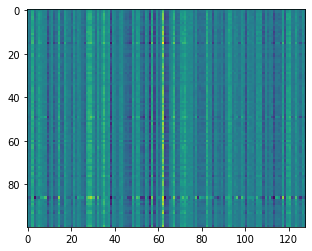

In [289]:
plt.imshow(embeddings)

In [290]:
embeddings

array([[ 8.62554065e-04, -1.57725811e-03,  7.92967994e-03, ...,
        -3.34244967e-03,  8.70856456e-04, -3.12542915e-03],
       [ 1.22367323e-03, -2.40933895e-03,  1.14681767e-02, ...,
        -3.78507376e-03,  3.25050205e-03, -3.87662649e-03],
       [ 6.35376084e-04, -4.83119488e-03,  1.23331705e-02, ...,
        -2.72279978e-03,  3.71459406e-03, -3.79580259e-03],
       ...,
       [ 1.34877989e-03, -1.91712379e-03,  1.04327453e-02, ...,
        -2.84612179e-03,  2.95229629e-03, -2.12794542e-03],
       [ 1.96444523e-03, -1.90186501e-03,  1.19501995e-02, ...,
        -3.82292271e-03,  3.23392986e-03, -2.96080112e-03],
       [-8.31484795e-05, -6.47127628e-03,  1.20019028e-02, ...,
        -4.43172455e-03,  4.06207191e-03, -4.24808264e-03]], dtype=float32)